In [2]:
%load_ext autoreload
%autoreload 2
import os
import sys
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imblearn as imb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from rdkit import Chem
from rdkit.Chem import Draw
from imblearn.under_sampling import RandomUnderSampler
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utils
logging.basicConfig(level=logging.INFO, stream=sys.stdout)
pd.set_option('display.max_colwidth', None)

In [3]:
smile_prop_df = pd.read_csv('/Users/radhi/Desktop/CAPSTONE_DATA/NEK_data_4Berkeley/NEK5/NEK5_1_uM_min_50_pct_binding_5fold_random_imbalanced.csv')

# Reading in the training set (folds 1-4) and the test set (fold 5)
smile_prop_train = smile_prop_df[smile_prop_df['fold'] != 'fold5'].drop(columns=['fold'])
smile_prop_test = smile_prop_df[smile_prop_df['fold'] == 'fold5'].drop(columns=['fold'])

# Converting the SMILES to RDKit mol objects and assigning name and activity to each mol object
mol_train = []
for i in smile_prop_train.index:
    m = Chem.MolFromSmiles(smile_prop_train.loc[i, 'base_rdkit_smiles'])
    if m:
        m.SetProp("_Name", smile_prop_train.loc[i, 'compound_id'])
        m.SetProp("Active", str(smile_prop_train.loc[i, 'active']))
        mol_train.append(utils.normalize(m))

mol_test = []
for i in smile_prop_test.index:
    m = Chem.MolFromSmiles(smile_prop_test.loc[i, 'base_rdkit_smiles'])
    if m:
        m.SetProp("_Name", smile_prop_test.loc[i, 'compound_id'])
        m.SetProp("Active", str(smile_prop_test.loc[i, 'active']))
        mol_test.append(utils.normalize(m))


[22:27:43] Initializing MetalDisconnector
[22:27:43] Running MetalDisconnector
[22:27:43] Initializing Normalizer
[22:27:43] Running Normalizer
[22:27:43] Running LargestFragmentChooser
[22:27:43] Running Uncharger
[22:27:43] Initializing MetalDisconnector
[22:27:43] Running MetalDisconnector
[22:27:43] Initializing Normalizer
[22:27:43] Running Normalizer
[22:27:43] Initializing MetalDisconnector
[22:27:43] Running MetalDisconnector
[22:27:43] Initializing Normalizer
[22:27:43] Running Normalizer
[22:27:43] Running LargestFragmentChooser
[22:27:43] Running Uncharger
[22:27:43] Initializing MetalDisconnector
[22:27:43] Running MetalDisconnector
[22:27:43] Initializing Normalizer
[22:27:43] Running Normalizer
[22:27:43] Initializing MetalDisconnector
[22:27:43] Running MetalDisconnector
[22:27:43] Initializing Normalizer
[22:27:43] Running Normalizer
[22:27:43] Running LargestFragmentChooser
[22:27:43] Running Uncharger
[22:27:43] Initializing MetalDisconnector
[22:27:43] Running MetalD

/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


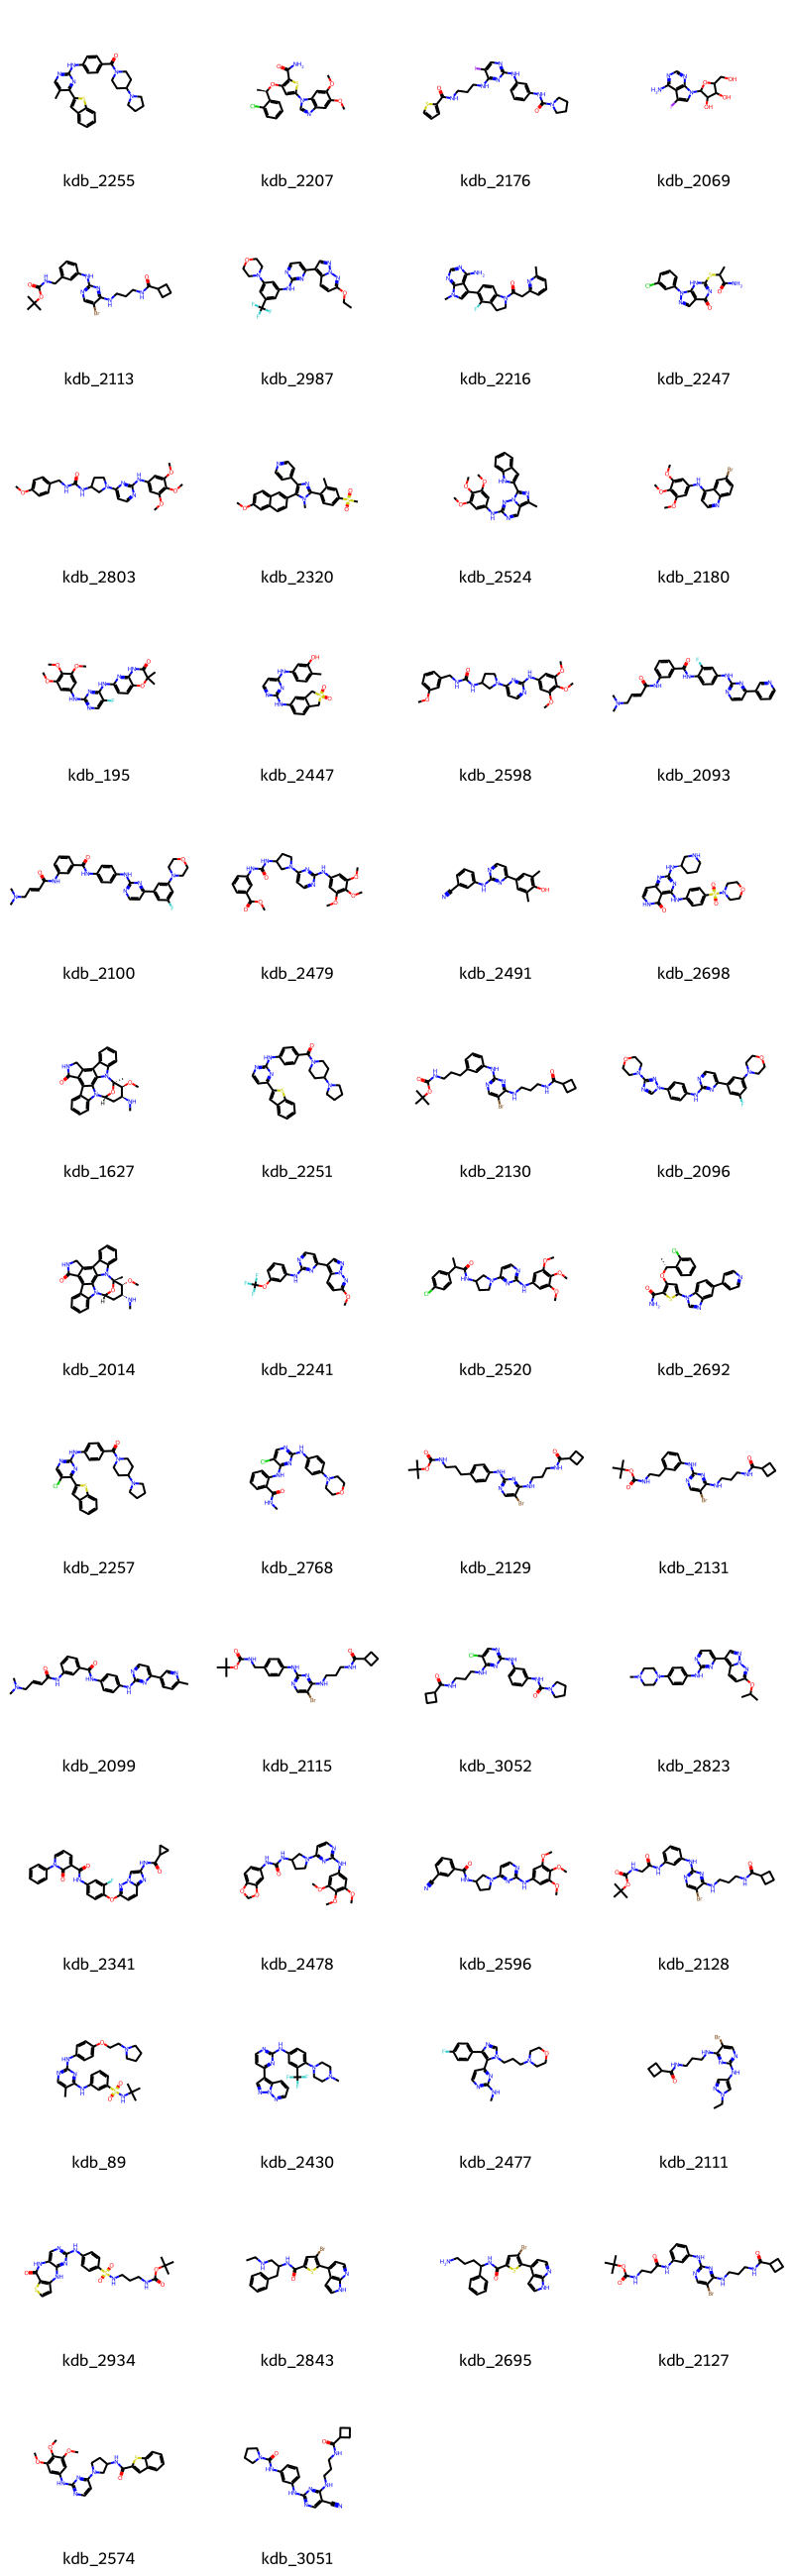

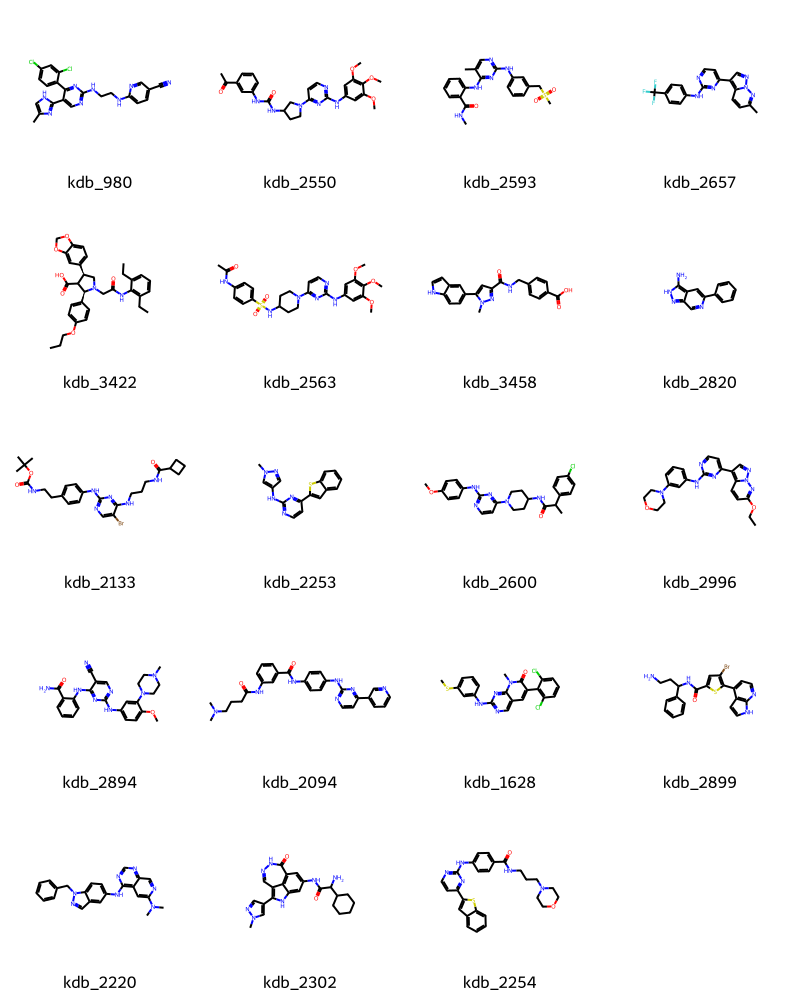

In [4]:
# Diaplaying the active compounds in the training and test set

active_train = []

for m in mol_train:
    if m.GetProp("Active") == '1':
        tmp=Chem.AllChem.Compute2DCoords(m)
        active_train.append(m)

display(Draw.MolsToGridImage(active_train,molsPerRow=4,subImgSize=(200,200),legends=[x.GetProp("_Name") for x in active_train]))

active_test = []
for m in mol_test:
    if m.GetProp("Active") == '1':
        tmp=Chem.AllChem.Compute2DCoords(m)
        active_test.append(m)

display(Draw.MolsToGridImage(active_test,molsPerRow=4,subImgSize=(200,200),legends=[x.GetProp("_Name") for x in active_test]))


In [5]:
import os
from rdkit import Chem

# Create the directory if it does not exist
directory = 'data/NEK5'
if not os.path.exists(directory):
    os.makedirs(directory)

# Proceed with writing your files
with Chem.SDWriter(os.path.join(directory, 'NEK5_1_uM_min_50_pct_binding_5fold_random_imbalanced_train.sdf')) as writer:
    for m in mol_train:
        writer.write(m)

with Chem.SDWriter(os.path.join(directory, 'NEK5_1_uM_min_50_pct_binding_5fold_random_imbalanced_test.sdf')) as writer:
    for m in mol_test:
        writer.write(m)


In [6]:
# Generating the existing and morgan fingerprints for the training and test set

X_existing_train = smile_prop_train.drop(columns=['compound_id', 'base_rdkit_smiles', 'active'])
X_existing_test = smile_prop_test.drop(columns=['compound_id', 'base_rdkit_smiles', 'active'])
y_train = smile_prop_train['active']
y_test = smile_prop_test['active']

# generate fingeprints: Morgan fingerprint with radius 2
fps = [Chem.AllChem.GetMorganFingerprintAsBitVect(m, 2) for m in mol_train]
# convert the RDKit explicit vectors into numpy arrays
X_morgan_train = []
for fp in fps:
  arr = np.zeros((1,))
  Chem.DataStructs.ConvertToNumpyArray(fp, arr)
  X_morgan_train.append(arr)

# generate fingeprints: Morgan fingerprint with radius 2
fps = [Chem.AllChem.GetMorganFingerprintAsBitVect(m, 2) for m in mol_test]
# convert the RDKit explicit vectors into numpy arrays
X_morgan_test = []
for fp in fps:
  arr = np.zeros((1,))
  Chem.DataStructs.ConvertToNumpyArray(fp, arr)
  X_morgan_test.append(arr)


In [7]:
# Function: Random Forest search model generator with stats
def rf_search_model(X_train, y_train, X_test, y_test,random_grid):
    rf = RandomForestClassifier(random_state = 42)
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    rf_random.fit(X_train, y_train)
    y_pred = rf_random.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    return accuracy, precision, recall, conf_matrix


def rf_model(X_train, y_train, X_test, y_test):
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    return rf, accuracy, precision, recall, conf_matrix


In [12]:
def zscore_adi(X_train, X_test, k):
    mean_distances = []
    for compound in X_train:
        distances = [euclidean(compound, other) for other in X_train if not np.array_equal(compound, other)]
        mean_distances.append(np.mean(sorted(distances)[:k]))
    mean_distances = np.array(mean_distances)
    mean_distance_mean = np.mean(mean_distances)
    mean_distance_std = np.std(mean_distances)
    adi_zscores = []
    for unseen_compound in X_test:
        distances_to_neighbors = [euclidean(unseen_compound, other) for other in X_train]
        mean_distance_unseen = np.mean(sorted(distances_to_neighbors)[:k])
        z_score = (mean_distance_unseen - mean_distance_mean) / mean_distance_std
        adi_zscores.append(z_score)
    return adi_zscores

In [8]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


Accuracy: 0.9311740890688259


Text(0.5, 1.0, 'Confusion Matrix test for NEK 5 RF Model w/ RD kit Fingerprints')

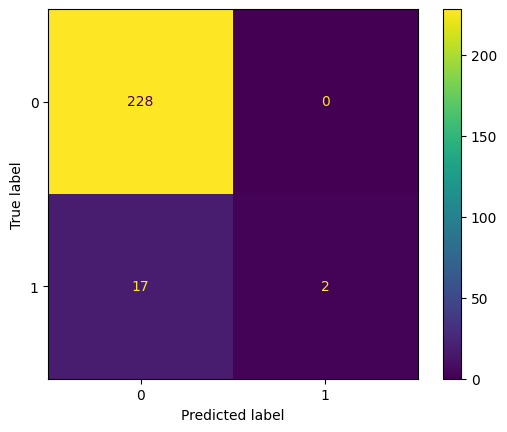

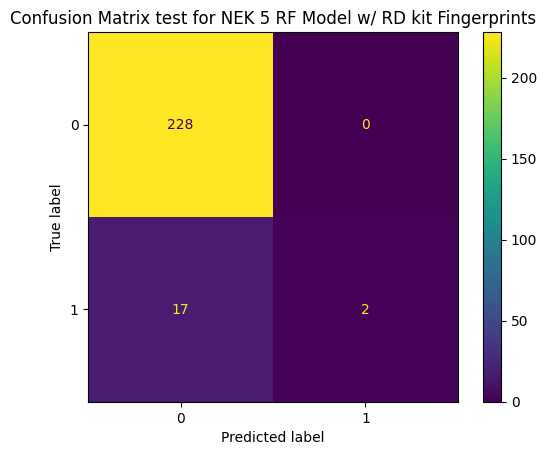

In [11]:
# RF model with existing fingerprints
rf, accuracy, precision, recall, conf_matrix = rf_model(X_existing_train, y_train, X_existing_test, y_test)


print("Accuracy:", accuracy)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot();
ax = disp.plot().ax_
ax.set_title('Confusion Matrix test for NEK 5 RF Model w/ RD kit Fingerprints')



Accuracy: 0.9352226720647774


Text(0.5, 1.0, 'Confusion Matrix test for NEK 5 RF Model w/ Morgan Fingerprints')

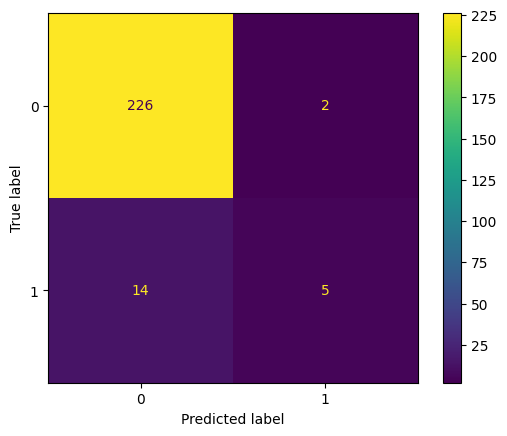

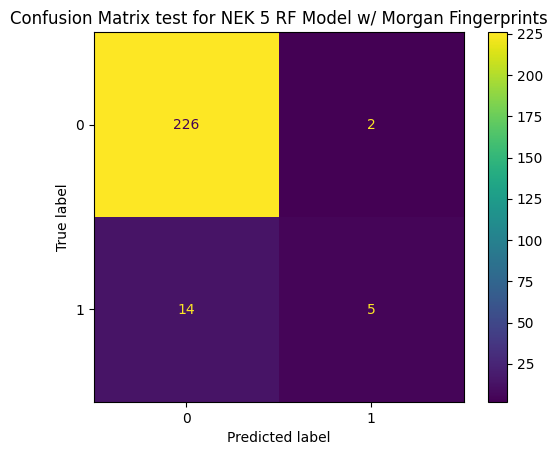

In [10]:
# RF model with morgan fingerprints
accuracy, precision, recall, conf_matrix = rf_model(X_morgan_train, y_train, X_morgan_test, y_test)

print("Accuracy:", accuracy)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot();
ax = disp.plot().ax_
ax.set_title('Confusion Matrix test for NEK 5 RF Model w/ Morgan Fingerprints')

Accuracy: 0.9392712550607287


Text(0.5, 1.0, 'Confusion Matrix test for NEK 5 RF Model w/ RD kit and oversampling')

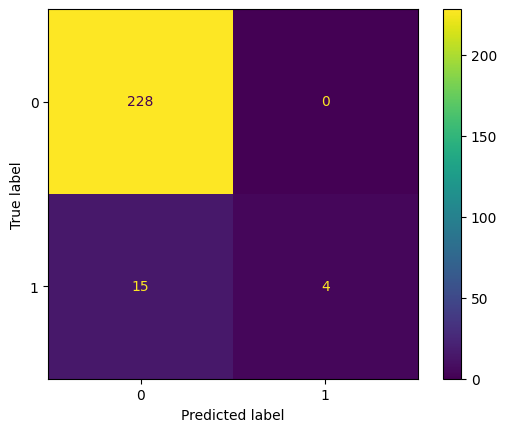

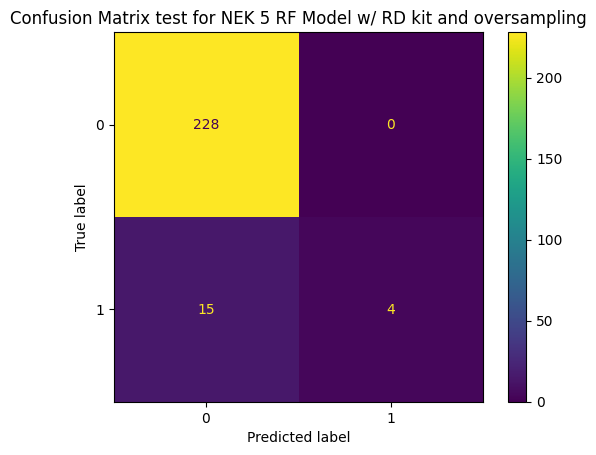

In [11]:
# RF model with existing fingerprints using oversampling
oversample = imb.over_sampling.RandomOverSampler()
X_os_train, y_os_train = oversample.fit_resample(X_existing_train, y_train)

accuracy, precision, recall, conf_matrix = rf_model(X_os_train, y_os_train, X_existing_test, y_test)

print("Accuracy:", accuracy)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot();
ax = disp.plot().ax_
ax.set_title('Confusion Matrix test for NEK 5 RF Model w/ RD kit and oversampling')

Accuracy: 0.9311740890688259


Text(0.5, 1.0, 'Confusion Matrix test for NEK 5 RF Model w/ RD kit and oversampling')

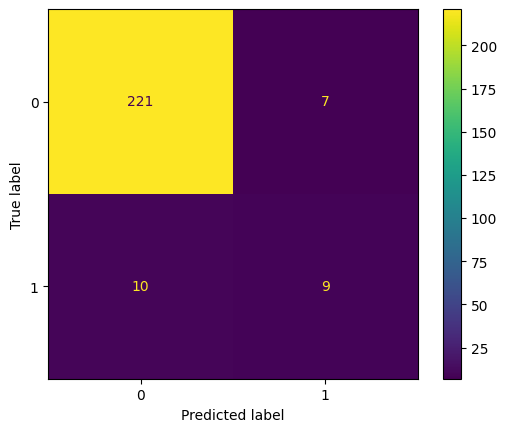

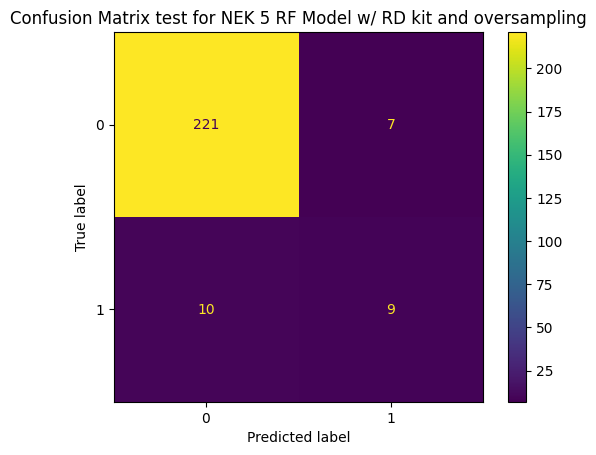

In [12]:
# RF model with morgan fingerprints using oversampling
oversample = imb.over_sampling.RandomOverSampler()
X_os_train, y_os_train = oversample.fit_resample(X_morgan_train, y_train)

accuracy, precision, recall, conf_matrix = rf_model(X_os_train, y_os_train, X_morgan_test, y_test)

print("Accuracy:", accuracy)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot();
ax = disp.plot().ax_
ax.set_title('Confusion Matrix test for NEK 5 RF Model w/ RD kit and oversampling')

Accuracy: 0.728744939271255


Text(0.5, 1.0, 'Confusion Matrix for NEK 5 RF Model w/ RD kit and Under Sampling')

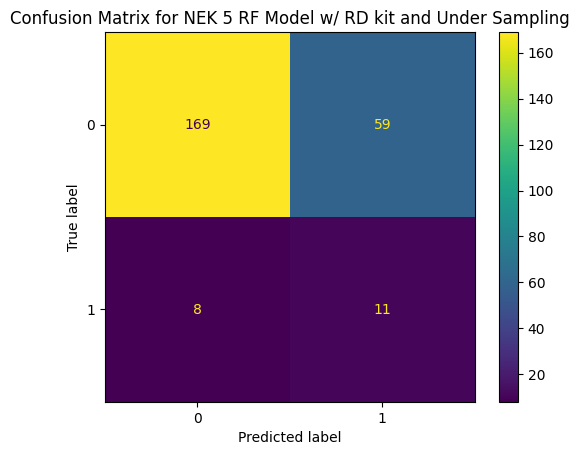

In [13]:


# Initialize the under-sampler
undersample = RandomUnderSampler()

# Apply the under-sampler to the training data
X_us_train, y_us_train = undersample.fit_resample(X_existing_train, y_train)

# Assuming rf_model is defined and works correctly
accuracy, precision, recall, conf_matrix = rf_model(X_us_train, y_us_train, X_existing_test, y_test)

print("Accuracy:", accuracy)

# Create and display the confusion matrix with a title

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
ax = disp.plot().ax_
ax.set_title('Confusion Matrix for NEK 5 RF Model w/ RD kit and Under Sampling')

Accuracy: 0.8502024291497976


Text(0.5, 1.0, 'Confusion Matrix for NEK 5 RF Model Morgan Fingerprint and Under Sampling')

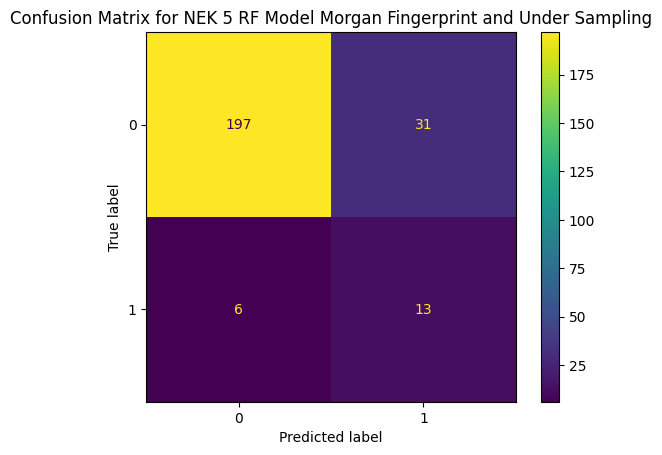

In [14]:
# Initialize the under-sampler
undersample = RandomUnderSampler()

# Apply the under-sampler to the training data
X_us_train, y_us_train = undersample.fit_resample(X_morgan_train, y_train)

# Assuming rf_model is defined and works correctly
accuracy, precision, recall, conf_matrix = rf_model(X_us_train, y_us_train, X_morgan_test, y_test)

print("Accuracy:", accuracy)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
ax = disp.plot().ax_
ax.set_title('Confusion Matrix for NEK 5 RF Model Morgan Fingerprint and Under Sampling')

Accuracy: 0.9311740890688259


Text(0.5, 1.0, 'Confusion Matrix test for NEK 5 RF Model w/  Morgan Fingerprint and oversampling')

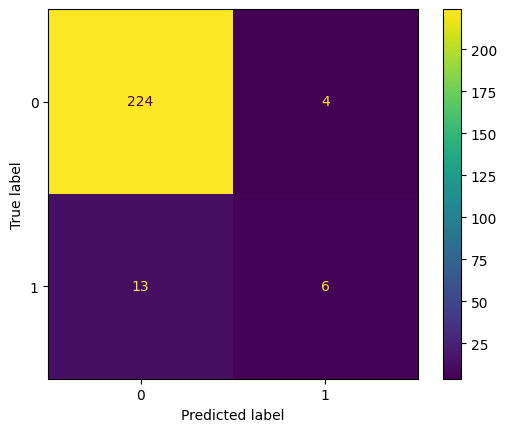

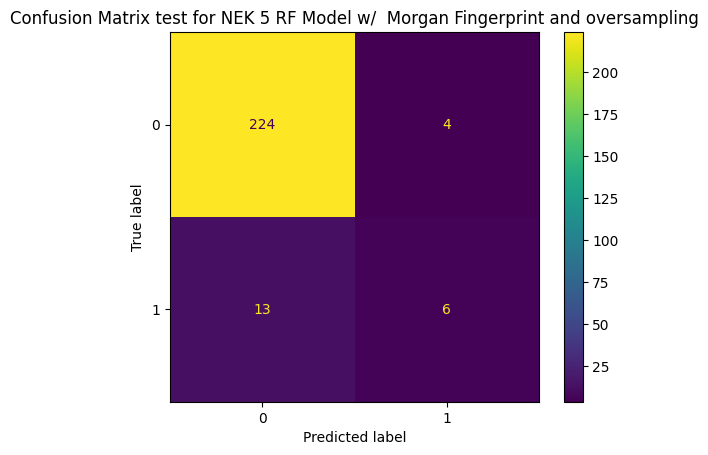

In [15]:

xgb_model = xgb.XGBClassifier(objective='binary:logistic')
xgb_model.fit(X_morgan_train, y_train)
accuracy = xgb_model.score(X_morgan_test, y_test)
conf_matrix = confusion_matrix(y_test, xgb_model.predict(X_morgan_test))

print("Accuracy:", accuracy)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot();
ax = disp.plot().ax_
ax.set_title('Confusion Matrix test for NEK 5 RF Model w/  Morgan Fingerprint and oversampling')

Accuracy: 0.9392712550607287


Text(0.5, 1.0, 'Confusion Matrix test for NEK 5 XG Boost Model w/ RD kit')

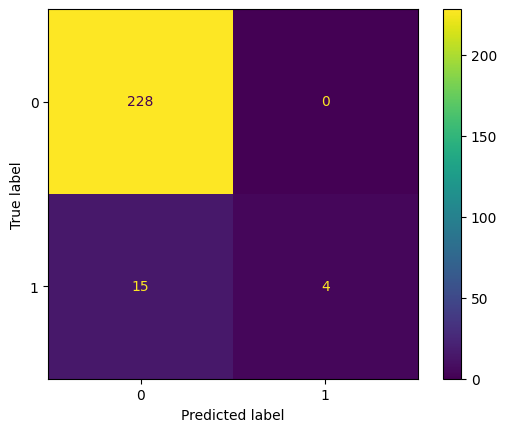

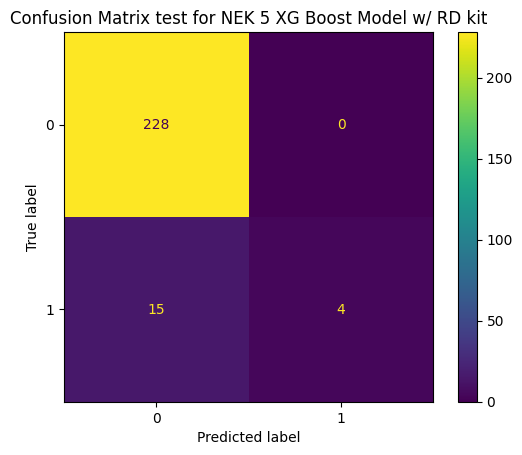

In [16]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic')
xgb_model.fit(X_existing_train, y_train)
accuracy = xgb_model.score(X_existing_test, y_test)
conf_matrix = confusion_matrix(y_test, xgb_model.predict(X_existing_test))

print("Accuracy:", accuracy)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot();
ax = disp.plot().ax_
ax.set_title('Confusion Matrix test for NEK 5 XG Boost Model w/ RD kit')

Accuracy: 0.9230769230769231


Text(0.5, 1.0, 'Confusion Matrix test for NEK 5 XG Boost Model w/ Morgan Fingerprint')

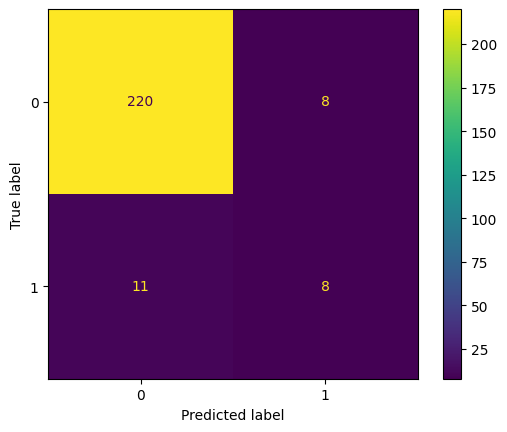

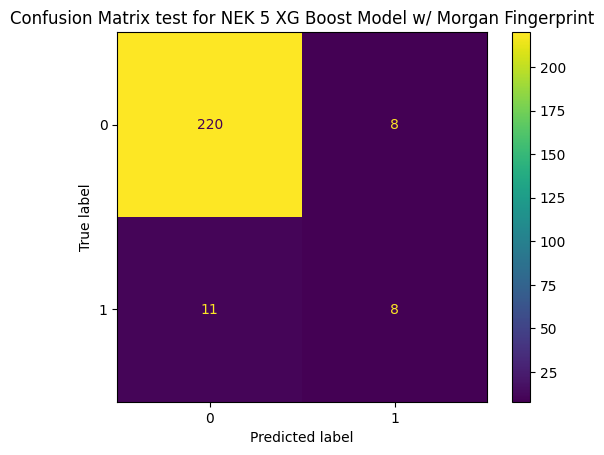

In [17]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic')
X_os_train, y_os_train = oversample.fit_resample(X_morgan_train, y_train)

xgb_model.fit(X_os_train, y_os_train)
accuracy = xgb_model.score(X_morgan_test, y_test)
conf_matrix = confusion_matrix(y_test, xgb_model.predict(X_morgan_test))

print("Accuracy:", accuracy)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot();
ax = disp.plot().ax_
ax.set_title('Confusion Matrix test for NEK 5 XG Boost Model w/ Morgan Fingerprint')

Accuracy: 0.9428571428571428


Text(0.5, 1.0, 'Confusion Matrix test for NEK 3 XG Boost Model w/ Morgan Fingerprint')

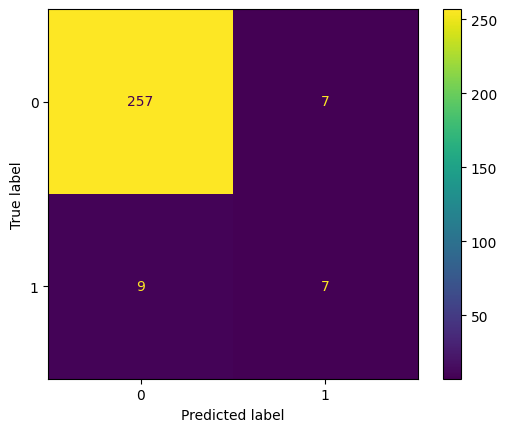

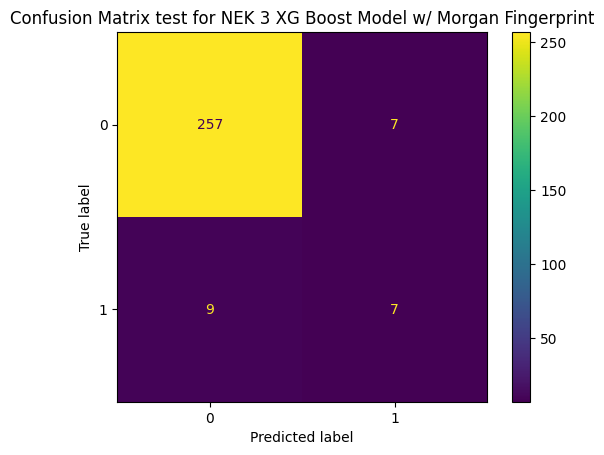

In [35]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic')
xgb_model.fit(X_morgan_train, y_train)
accuracy = xgb_model.score(X_morgan_test, y_test)
conf_matrix = confusion_matrix(y_test, xgb_model.predict(X_morgan_test))

print("Accuracy:", accuracy)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot();
ax = disp.plot().ax_
ax.set_title('Confusion Matrix test for NEK 5 XG Boost Model w/ Morgan Fingerprint')